# Machine Learning Demonstrations

In this notebook, we showcase how to use the kdb+/q clustering library, contained within the ML-Toolkit, and to plot outputs using embedPy. Below we demonstrate how to use each algorithm contained within the toolkit and how to use the library in conjunction with real-world data.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## Machine Learning Toolkit

The ML-Toolkit contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm, cross validation functions and clustering algorithms. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

The clustering library contained within the toolkit is used throughout this notebook and can be loaded using the below syntax along with graphics functions used within this notebook.

In [1]:
\l ml/ml.q
.ml.loadfile`:clust/init.q

\l ../utils/graphics.q

# Clustering

Clustering is a technique used in both data mining and machine learning to group similar data points together in order to identify patterns in their distributions. Some real-world examples include segmenting customers based on spending habits, detecting fraudulent activity given patterns in past behaviour and optimizing delivery routes based on customer locations.

The task of clustering data can be carried out using a number of algorithms. The algorithms defined in the toolkit work based on distinct clustering methodologies namely; connectivity-based, centroid-based or density-based models. Each type of algorithm defines clusters based on:

-   **Centroid-based** - distances from single points which represent the cluster.
-   **Density-based** - clusters being within a certain distance of each other and in defined concentrations.
-   **Connectivity-based** - distances between individual data points.

Each algorithm works by iteratively joining, separating or reassigning points until the desired number of clusters have been achieved.

The process of finding the correct cluster for each data point is a case of trial and error, where parameters must be altered in order to find the optimum solution.

## Sections

This notebook is split into 2 distinct sections, which cover the different algorithms contained in the toolkit, along with a real-world example.

[**Algorithms**](#Algorithms):
1. Centroid-based: [K-Means](#K-Means)
2. Density-based: [DBSCAN](#DBSCAN), [Affinity Propagation](#Affinity-Propagation)
3. Connectivity-based: [Hierarchical](#Hierarchical), [CURE](#CURE)

**Real-World Example**:
4. [Chocolate Bar Ratings](#Chocolate-Bar-Ratings)

---

## Load scripts and import functions

Throughout this notebook, we cluster data created in q and selected from the `sklearn` datasets library. Results are then visualized using `matplotlib` and `scipy`'s dendrogram functionality.

Each of the libraries are imported using embedPy, as shown below.

In [2]:
/ import matplotlib from Python
plt:.p.import`matplotlib.pyplot

/ dendrogram plot
dgramplt:.p.import[`scipy.cluster][`:hierarchy]`:dendrogram

/ sklearn samples
skldata:.p.import`sklearn.datasets
blobs:skldata[`:make_blobs;<]
moons:skldata[`:make_moons;<]

---

<a id='Algorithms'></a>
# Algorithms

In this section we showcase how to use the algorithms contained within the ML-Toolkit. We start with descriptions of centroid and density-based clustering algorithms, followed by connectivity-based algorithms.

Fit and predict methods have been provided for each algorithm, with additional update methods provided for K-Means and DBSCAN. Full documentation of all the methods used can be found at [code.kx.com](https://code.kx.com/q/ml/toolkit/clustering/).

Before continuing through the notebook, it is worth noting that for simplicity the algorithms below have been applied to 2D datasets. All algorithms can be applied in higher dimensional examples.

---

<a id='K-Means'></a>
## K-Means

Clustering data with the k-means algorithm begins with the selection of *k* data points as cluster centres. Data points are then assigned to the nearest cluster centres.

The algorithm follows an iterative refinement process which will run *n* times, updating the cluster centres and assigned points during each iteration.

Advantages of k-means include:
- The simplicity of the algorithm, both to implement and run, makes it extremely efficient and easy to understand
- Creating centroids is an easy way to perform data reduction

### Fit K-Means

In this example, we show how k-means can be used to identify clusters in datasets with 1000 random data points and no apparent structure.

The algorithm is able to cluster the data into evenly spaced clusters in comparison to other denisty or distance based algorithms.

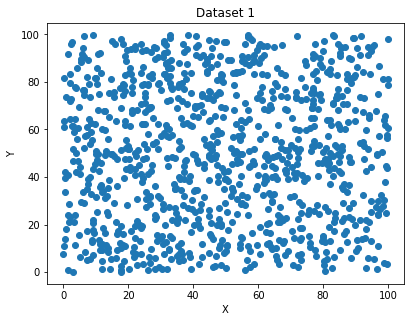

In [3]:
/ set seed so dataset can be reproduced
\S 20

/ generate dataset
d1:2 1000#2000?100.

/ plot data points
.util.plotDataset[d1;"Dataset 1"]

In this case, we want to identify `3` clusters across `10` iterations of the algorithm using Euclidean squared distances. Note that in this case, k-means will be initialized using kmeans++.

Note that cluster centres will be plotted in pink.

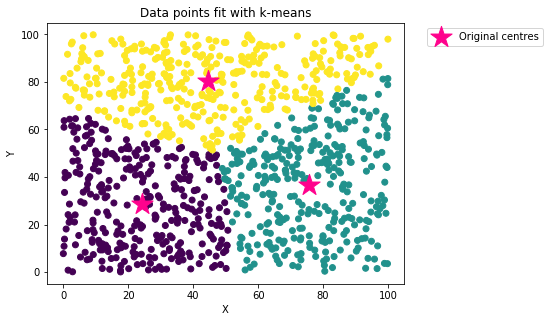

In [4]:
df:`e2dist  / distance function
k:3         / number of clusters
dict:enlist[`iter]!enlist 10

/ fit kmeans to data
kmeansMdl:.ml.clust.kmeans.fit[d1;df;k;dict]

/ plot resulting clusters
.util.plotKMeans[d1;kmeansMdl;enlist[`modelInfo]!enlist (::);"Data points fit with k-means"]

### Predict on new data

We can predict the clusters of new data points based on previously fitted k-means models using the function `.ml.clust.kmeans.predict` provided within the toolkit.

This is demonstrated in the example below, where we start by generating 100 random data points. We will treat the clusters generated from `d1` as our training set and plot our new testing points in red with respect to the previous results.

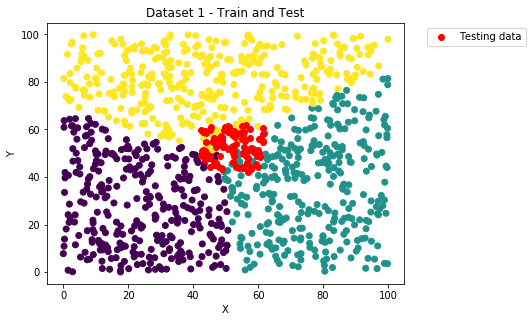

In [5]:
/ generate testing data
d1tst:2 100#42+200?20.

/ extract clusters
kmeansClust:kmeansMdl.modelInfo.clust

/ plot compared to training clusters
.util.plotTrainTest[d1;d1tst;"Dataset 1 - Train and Test";kmeansClust]

Clusters can then be predicted for the testing set using the previously fitted k-means model contained within `r1`.

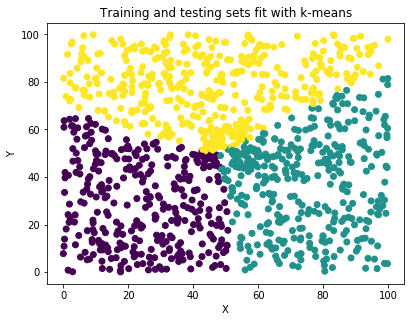

In [6]:
/ predict new clusters
kmeansPred:kmeansMdl.predict[d1tst]

/ join all clusters
kmeansClustsAll:kmeansClust,kmeansPred

/ plot resulting clusters
.util.plotCluster[d1,'d1tst;"Training and testing sets fit with k-means";kmeansClustsAll]

### Update model

We can also update our k-means model produced by the training set to include the testing points. 

This is demonstrated in the plot below where new clusters have been plotted, with updated centres in green.

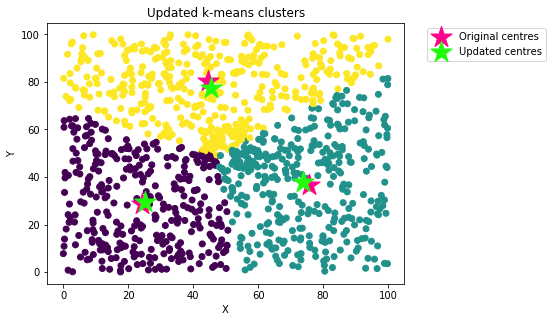

In [7]:
/ update fitted k-means model
kmeansUpd:kmeansMdl.update[d1tst]

/ plot resulting clusters
.util.plotKMeans[d1,'d1tst;kmeansMdl;kmeansUpd;"Updated k-means clusters"]

---

<a id='DBSCAN'></a>
## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

The DBSCAN algorithm groups points together that are closely packed in areas of high-density. Any points in low-density regions are seen as outliers.

DBSCAN does not require the user to pass in the number of clusters, it will determine the optimum number for you. This decision is based on a minimum number of points per cluster and an epsilon radius which describes the neighbourhood of each point, which must both be passed in as inputs.

Advantages of DBSCAN include:
- The number of clusters does not need to be known prior to use
- The algorithm is extremely useful for anomaly detection, and will return outliers as a separate cluster

### Fit DBSCAN

Below we show how DBSCAN can be used to cluster data points in odd shapes, such as a crescent moons - generated using the sklearn [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

Distance-based models would struggle to correctly classify datasets like the one below as clusters are in close proximity which means points could easily be included in the wrong cluster. Density based models like DBSCAN are able to distinguish between the clusters given that points in each are densely packed.

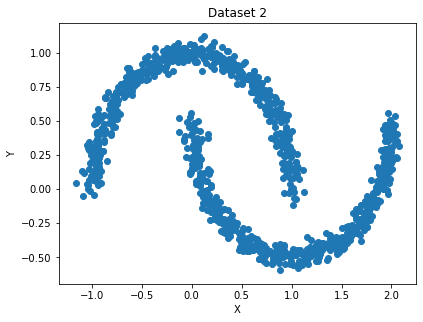

In [8]:
/ generate dataset
d2:flip moons[`n_samples pykw 1000;`noise pykw 0.05]0

/ plot data points
.util.plotDataset[d2;"Dataset 2"]

In this example we used Euclidean squared distances with a minimum of `5` points required per cluster and a neighbourhood radius of `0.04`.

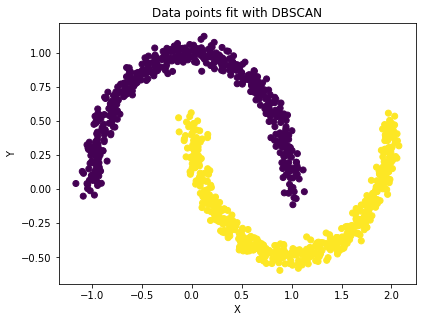

In [9]:
df:`e2dist  / distance functions
minpts:5    / minimum points per cluster
nbhrad:.04  / neighbourhood radius

/ fit dbscan to data
dbMdl:.ml.clust.dbscan.fit[d2;df;minpts;nbhrad]

/ extract clusters
dbClusts:dbMdl.modelInfo.clust

/ plot resulting clusters
.util.plotCluster[d2;"Data points fit with DBSCAN";dbClusts]

### Predict on new data

Given the fitted model above, we can now generate a new set of data points and predict whether they will belong to the two clusters above or if they will be defined as an outlier by the algorithm.

We start by generating 10 data points and plotting them in red against our original dataset.

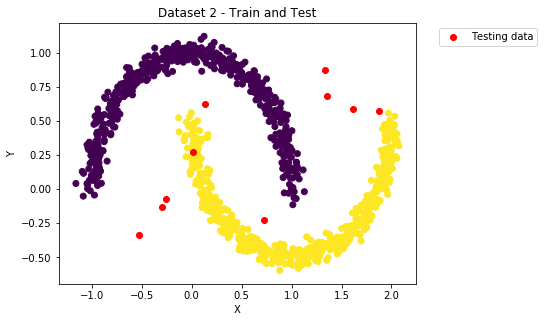

In [10]:
/ generate testing data
d2tst:(-1+10?3.;-.5+10?1.5)

/ plot compared to training clusters
.util.plotTrainTest[d2;d2tst;"Dataset 2 - Train and Test";dbClusts]

Clusters can then be predicted using the previously fitted model `r2`.

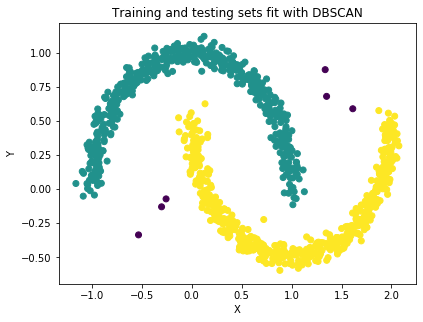

In [11]:
/ predict new clusters
dbPred:dbMdl.predict[d2tst]

/ join all clusters
dbClustsAll:dbClusts,dbPred

/ plot resulting clusters
.util.plotCluster[d2,'d2tst;"Training and testing sets fit with DBSCAN";dbClustsAll]

We see that a couple of the points are represented in the current clusters, while the rest are marked as outliers.

### Update model

We can now update the clusters using `.ml.clust.dbscan.update` which will return an updated model including the new data points.

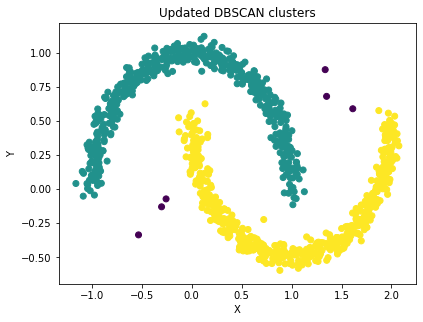

In [12]:
/ update fitted dbscan model
dbUpd:dbMdl.update[d2tst]

/ extract clusters
dbClusts:dbUpd.modelInfo.clust

/ plot resulting clusters
.util.plotCluster[dbUpd.modelInfo.data;"Updated DBSCAN clusters";dbClusts]

---

<a id='Affinity-Propagation'></a>
## Affinity Propagation

Affinity propagation works by grouping data together based on the similarity between points. It then finds *k* exemplars which best represent the points in each cluster.

Similarly to DBSCAN, the algorithm does not require the user to input the number of clusters and will determine the optimum solution by exchanging real-valued messages between points until a high-valued set of exemplars are produced.

A damping coefficient is used to reduce the availability and responsibility of messages passed between points, while the preference value is used to set the diagonal values of the similarity matrix.

Advantages of affinity propagration include:
- The number of clusters does not need to be known prior to use
- The algorithm is highly scalable and can be applied to large similarity matrices

### Fit Affinity Propagation

In the example below we create clusters from 1000 points using the sklearn [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs) function.

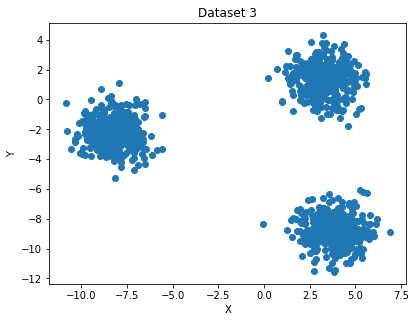

In [13]:
/ generate dataset
d3:flip blobs[`n_samples pykw 1000;`random_state pykw 500]0

/ plot data points
.util.plotDataset[d3;"Dataset 3"]

Below we demonstrate using the fit function how to cluster the above dataset. In the example, `0.8` is passed as the damping coefficient, while `min` is used to calculate the diagonal of the similarity matrix.

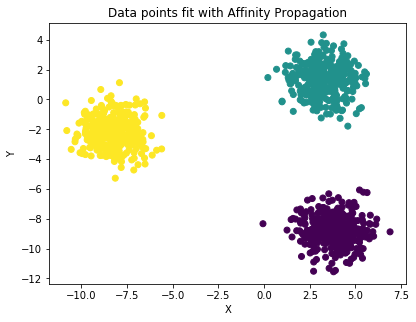

In [14]:
df:`nege2dist  / distance function
dmp:.8         / damping coefficient
diag:min       / diagonal function
iter:(::)      / iteration dictionary

/ fit ap to data
apMdl:.ml.clust.ap.fit[d3;df;dmp;diag;iter]

/ extract clusters
apClusts:apMdl.modelInfo.clust

/ plot resulting clusters
.util.plotCluster[d3;"Data points fit with Affinity Propagation";apClusts]

We can then demostrate how well the clusters have been selected by using the [Davies Bouldin](https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index) index function contained in the toolkit. 

The index takes in the dataset and resulting clusters and will return a floating point value with a minimum score of 0. Lower values indicate better clustering.

In [15]:
.ml.clust.daviesBouldin[d3;apClusts]

0.2374849


### Predict on new data

Similarly to the other algorithms, Affinity Propagation also has a predict method that allows us to predict which cluster new data points should belong to.

We demonstrate this below by generating 10 random data points and plotting their predicted clusters based on the previously fitted model `r3`.

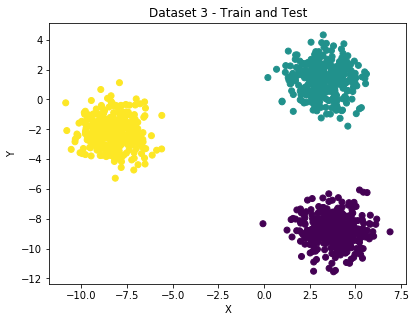

In [16]:
/ generate testing data
d3tst:(-10+10?17.5;-12+10?16.)

/ plot compared to training clusters
.util.plotCluster[d3;"Dataset 3 - Train and Test";apClusts]

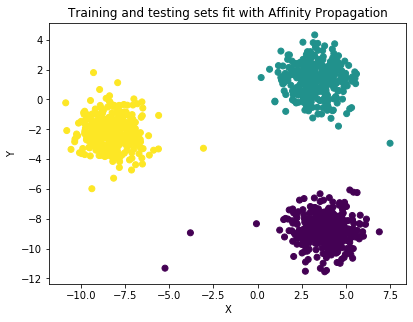

In [17]:
/ predict new clusters
apPred:apMdl.predict[d3tst]

/ plot resulting clusters
.util.plotCluster[d3,'d3tst;"Training and testing sets fit with Affinity Propagation";apClusts,apPred]

---

<a id='Hierarchical'></a>
## Hierarchical Clustering

As the name suggests, hierarchical clustering algorithms create hierarchies of clusters. The implementation described here follows an agglomerative approach, where each data point is initially treated as its own cluster.

There are 5 possible linkages in hierarchical clustering: ``` `single`complete`average`centroid`ward```

Euclidean, Euclidean squared or Manhattan distances can be used with each linkage, except for ward which only works with Euclidean squared distances and centroid which only works with Euclidean distances (both `e2dist` and `edist` respectively).

In the implementation below, both q and C implementations of a k-dimensional (k-d) tree are available for the single and centroid implementations to store the representative points of each cluster (more information [here](https://code.kx.com/v2/ml/toolkit/clustering/kdtree)).

At each step, the two closest clusters (defined by the linkage) are merged until only one cluster remains, which contains all of the data points. Results are represented in a dendrogram, used to suggest the “appropriate” number of clusters in the data. 

Advantages of hierarchical clustering include:
- The algorithms can be used to produce a dendrogram structure, which is extremely informative compared to other algorithms.
- The different methods available within hierarchical clustering make it applicable to a wide range of datasets.

### Fit hierarchical

The first example uses `ward` linkage with Euclidean squared distances. Blobs are generated as before, using the `sklearn` datasets library. `10` data points are used and a random state is again chosen.

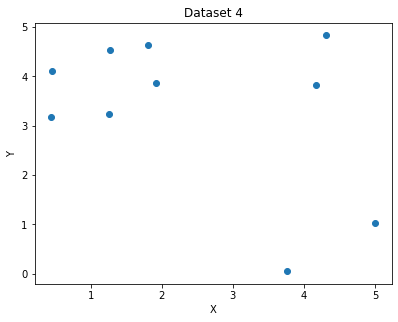

In [18]:
/ set seed
\S 10

/ generate dataset
d4:2 10#20?5.

/ plot data points
.util.plotDataset[d4;"Dataset 4"]

In the first case, we demostrate how to use ward linkage in conjunction with Euclidean squared distances. 

We start by fitting the hierarchical ward method to our data, producing a dendrogram structure. This can then be plotted using the Scipy [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) function, imported as `dgramplt` below.

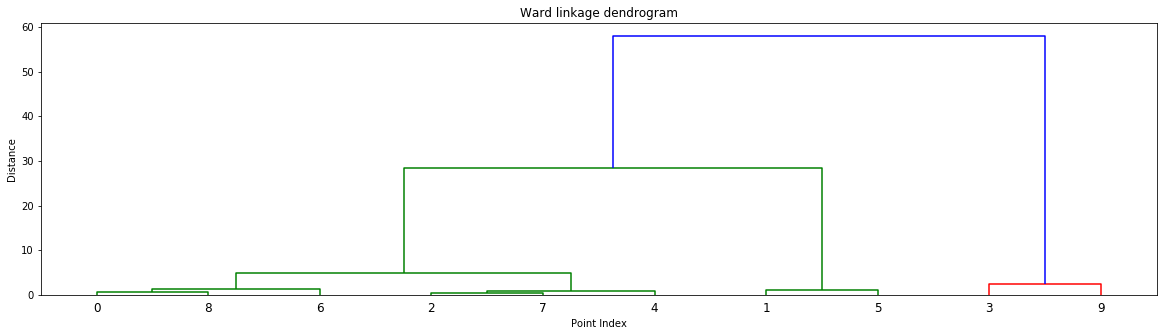

In [19]:
dfw:`e2dist  / distance function
lfw:`ward    / linkage function

/ produce dendrogram table based on ward linkage
wardMdl:.ml.clust.hc.fit[d4;dfw;lfw]

/ extract the dendrogram
wardDgram:wardMdl.modelInfo.dgram

/ plot dendrogram
plt[`:figure][`figsize pykw 20 5];
dgramplt flip value flip wardDgram;
plt[`:title]"Ward linkage dendrogram";
plt[`:xlabel]"Point Index";
plt[`:ylabel]"Distance";
plt[`:show][];

We can use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to decide how many clusters to group the data into by passing in our dataset, the distance metric and the maximum number of clusters.

The function will return the elbow score for each possible k value from 2 to until the maximum number supplied.

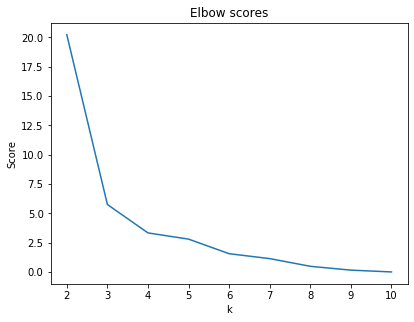

In [20]:
kmax:10         / maximum number of clusters
xticks:2+til 9  / plot xticks for scores returned - from 2 clusters to kmax

/ calculate elbow scores
scores:.ml.clust.elbow[d4;dfw;kmax]

/ plot scores and find "elbow"
plt[`:plot][xticks;scores];
plt[`:title]"Elbow scores";
plt[`:xlabel]"k";
plt[`:ylabel]"Score";
plt[`:show][];

We can see that, as expected, the elbow method suggests that the data should be grouped into 3 clusters.

We can cut the dendrogram into a user defined number of clusters or at a user defined distance using `.ml.clust.hc.cutk` or `.ml.clust.hc.cutdist` respectively. 

Below we pass in our dendrogram and cut clusters to the function `.util.plotHCResults` and visualize the results.

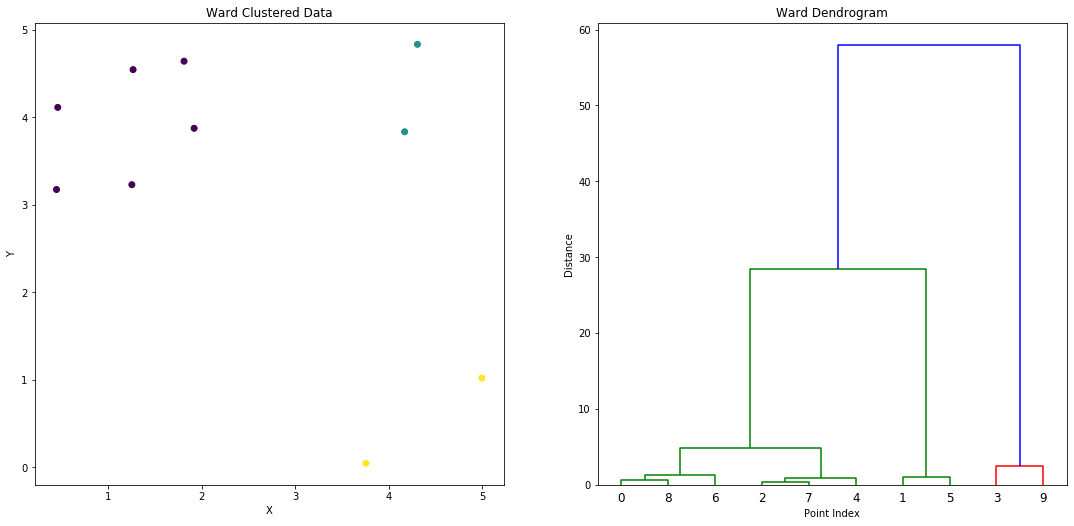

In [21]:
cuttyp:`k  / method of dendrogram cutting
cutval:3   / number of clusters

/ cut the dendrogram
wardClust:.ml.clust.hc.cutK[wardMdl;cutval]

/ generate plots
.util.plotHCResults[d4;lfw;wardMdl;wardClust]

Then using the same method as above, we can produce results for `complete` linkage and compare.

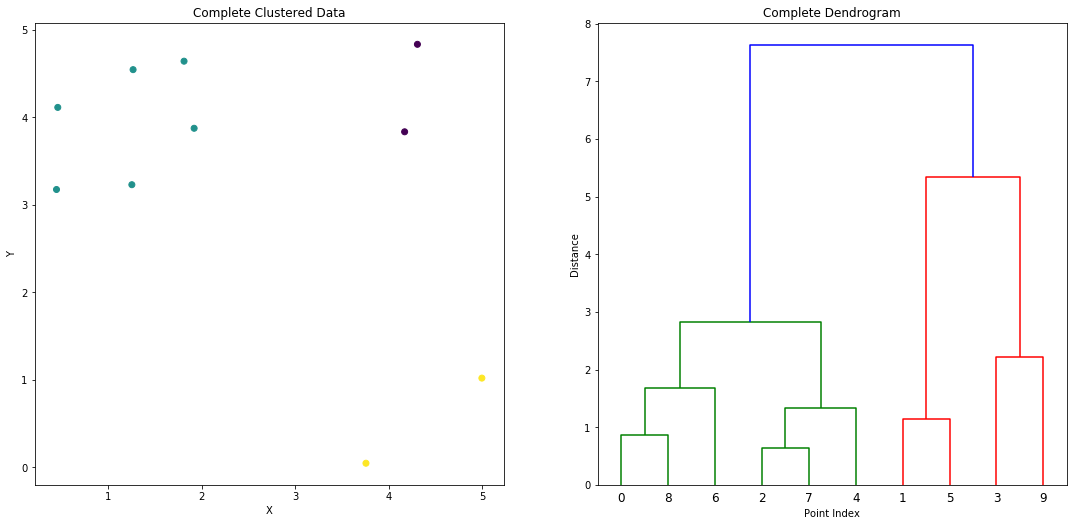

In [22]:
dfc:`mdist    / distance function
lfc:`complete / linkage function

/ produce dendrogram table based on ward linkage
completeMdl2:.ml.clust.hc.fit[d4;dfc;lfc]

/ cut the dendrogram
completeClust:.ml.clust.hc.cutK[completeMdl2;cutval]

/ generate plots
.util.plotHCResults[d4;lfc;completeMdl2;completeClust]

We see that although the resulting clusters are the same in both cases, the dendrograms are extremely different.

We can then check how well the data has been clustered in both methods, with regards to their respective distance metrics, using the Silhouette coefficient.

In [23]:
/ ward linkage
.ml.clust.silhouette[d4;dfw;wardClust`clust;1b]

/ centroid linkage
.ml.clust.silhouette[d4;dfc;completeClust`clust;1b]

0.8409111


0.5854309


### Predict on new data

Again it is possible to make predictions given our previously fitted hierarchical models.

Below we demonstrate how to make predictions for the ward model produced above, starting by generating 10 random points.

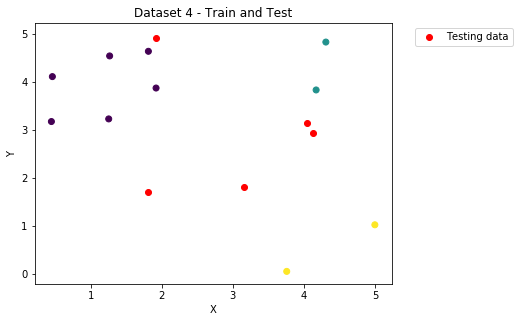

In [25]:
/ generate testing set
d4tst:2 5#10?5.

/ plot compared to training data
.util.plotTrainTest[d4;d4tst;"Dataset 4 - Train and Test";wardClust`clust]

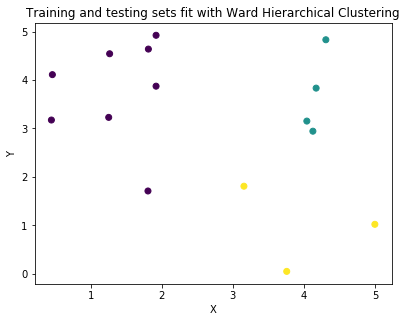

In [26]:
/ predict clusters using ward model
wardPred:wardMdl.predict[d4tst;enlist[`k]!enlist cutval]

/ join all clusters
wardClustsAll:wardClust[`clust],wardPred

/ plot resulting clusters
.util.plotCluster[d4,'d4tst;"Training and testing sets fit with Ward Hierarchical Clustering";wardClustsAll]

---

<a id='CURE'></a>
## CURE (Clustering Using REpresentatives)

CURE clustering is a distance-based technique used to deal with datasets containing outliers and clusters of varying sizes and shapes.

Each cluster is represented by a specified number of representative points, chosen by taking the the most scattered points in each cluster and compressing them towards the cluster centre by a fixed amount.

Similarly to Hierarchial, the q and C implementations of the k-d trees can be used.

Advantages of CURE include:
- The use of a k-dimensional tree makes the algorithm extremely efficient and highly scalable.
- The use of compression allows CURE to perform well in cases where the dataset provided contains outliers or has clusters of varying sizes and shapes.

### Fit CURE

The below code creates a dataset of points belonging to 4 distinct clusters, 3 of which share the same centre. Most clustering algorithms do not perform well when presented with data in concentric circles. 

Note that the process has been random seeded so that results can be replicated.

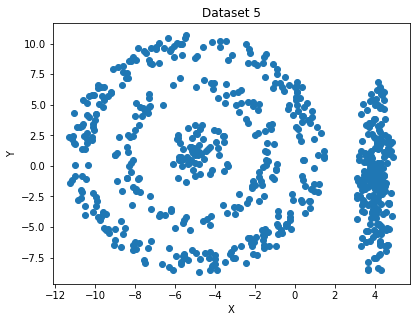

In [27]:
/ set seed
\S 20

/ generate dataset
dsc:{[n;r;s](r+n?s-r)*/:(cos;sin)@\:4*n?acos 0}
d5 :flip(-5 1)+(1 1.5)*dsc[1000; 0;1.8],'dsc[2000;3.1;4.2],'dsc[4000;5.2;6.5]
d5,:flip(4 -1)+(1 8)*dsc[4000; 0;1.]
d5@:neg[700&count d5]?count d5
d5:flip d5

/ plot data points
.util.plotDataset[d5;"Dataset 5"]

By using representative points, CURE is able to perform well when applied to these kinds of datasets.

The below applies CURE to the dataset, using Euclidean squared distances, `50` representative points and `0` compression. Below we follow the same method as the hierarchical methods above, plotting the dendrogram first, followed by splitting into `4` clusters.

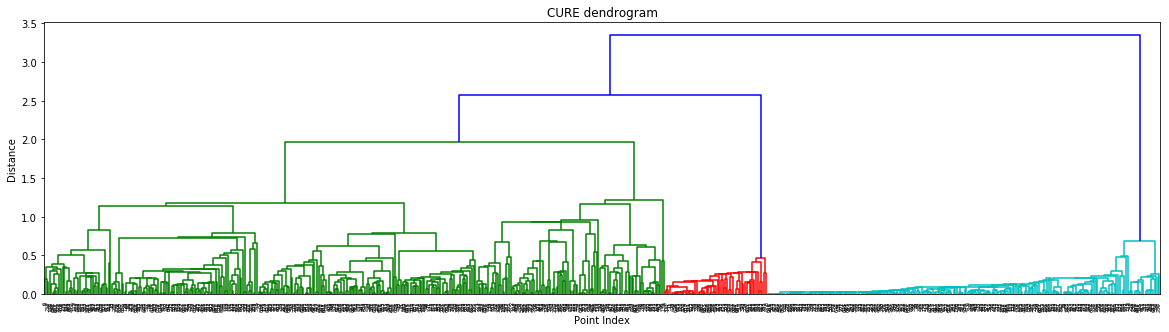

In [28]:
df:`e2dist  / distance function
nrep:50     / number of representative points
comp:0      / compression

/ generate dendrogram table
cureMdl:.ml.clust.cure.fit[d5;df;nrep;comp]

/ extract the dendrogram
cureDgram:cureMdl.modelInfo.dgram

/ plot dendrogram
plt[`:figure][`figsize pykw 20 5];
dgramplt flip value flip cureDgram;
plt[`:title]"CURE dendrogram";
plt[`:xlabel]"Point Index";
plt[`:ylabel]"Distance";
plt[`:show][];

As with the hierarchical methods above, we can use `.ml.clust.cure.cutk` or `.ml.clust.cure.cutdist` to cut the dendrogram into a user defined number of clusters or at a user defined distance.

Below we use the `cutk` method to separate our data into 4 clusters.

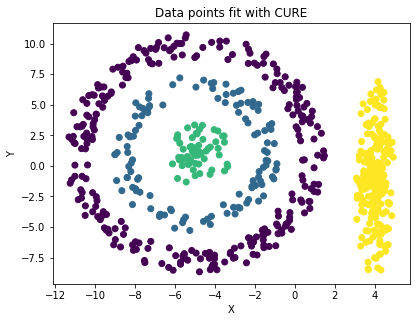

In [29]:
k:4  / number of clusters

/ cut dendrogram
cureCut:.ml.clust.cure.cutK[cureMdl;k]

/ extract the clusters
cureClusts:cureCut.clust

/ plot resulting clusters
.util.plotCluster[d5;"Data points fit with CURE";cureClusts]

### Predict clusters using fitted CURE model

Predictions are then made by passing in testing data points with the configuration dictionary returned above.

Here we generate a further 10 random points.

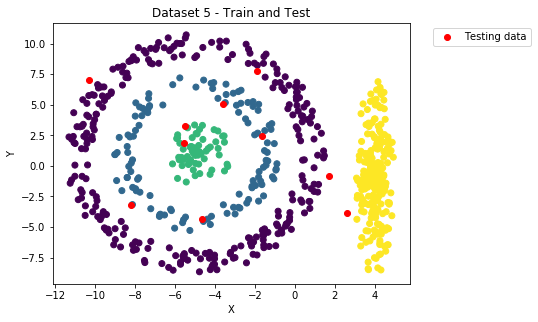

In [30]:
/ generate testing data
d5tst:(-12+10?16.;-7.5+10?17.5)

/ plot compared to training clusters
.util.plotTrainTest[d5;d5tst;"Dataset 5 - Train and Test";cureClusts]

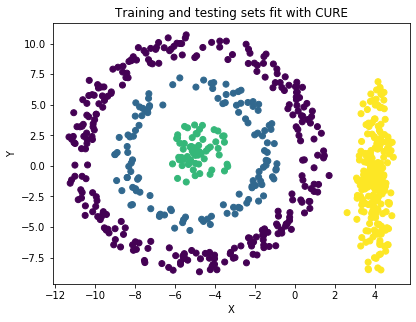

In [31]:
/ predict clusters using ward model
curePred:cureMdl.predict[d5tst;enlist[`k]!enlist k]

/ join all clusters
cureClustsAll:cureClusts,curePred

/ plot resulting clusters
.util.plotCluster[d5,'d5tst;"Training and testing sets fit with CURE";cureClustsAll]

---

# Real-World Example

<a id='Chocolate-Bar-Ratings'></a>
## Chocolate Bar Ratings

In the example below, we look at the kaggle [Chocolate Bar Ratings dataset](https://www.kaggle.com/rtatman/chocolate-bar-ratings), compiled by Brady Brelinski, the founder of the Manhattan Chocolate Society.

The dataset contains around 1,800 expert ratings for individual chocolate bars collected between 2006-2017. There is a focus on plain dark chocolate, with information on the origin and cocoa content of each bar produced. We will look specifically at the features for **cocoa percentage**, **rating** and **review date** of each chocolate bar.

Each bar is rated using the below scale, from worst to best:
1. **Unpleasant** - mostly unpalatable
2. **Disappointing** - passable, but contains at least 1 significant flaw
3. **Satisfactory** to 3.75. **Praiseworthy** - well made, with special qualities
4. **Premium** - superior flavor development, character and style
5. **Elite** - transcending beyond the ordinary limits

Where ratings are based on 4 main factors: *flavor, texture, aftermelt* and *overall opinion*, with flavor being the most important.

The aim in this example is to detect any outliers contained in the dataset using the clustering library contained in the ML-Toolkit. Additonal utility functions have also been defined below.

In [ ]:
/ utils functions

\d .ml
mode:{$[98h~t:type x;i.mode_calc each flip x;99h~t;i.mode_calc each x;i.mode_calc x]}
i.mode_calc:{n?max n:count each group x}
describe_mode:{key[d]!update mode:value .ml.mode x from value d:.automl.prep.i.describe x}

### Load data

In the below cell, we load in the chocolate dataset and return the shape of the features of interest, namely `cocoa_pcnt`, `rating`, `review_dt`.

<div class="alert alert-danger">
The data loaded in below has been preprocessed prior to use in this notebook to remove punctuation characters, convert null `bean_typ characters to <i>"Unknown"</i> and change column names to those more appropriate for q.
</div>

In [ ]:
-1"Full dataset:\n";
show 5#cocoa:("SSISSSIFF";(),",")0:`:../data/cocoa.csv

-1"\nRelevant columns:\n";
show 5#d:select cocoa_pcnt,rating,review_dt from cocoa

-1"\nRelevant column info:\n";
show .ml.stats.describe d

We can see that the majority of reviews were carried out in 2015, with most bars receiving a pretty average score of 3.5. The focus on dark chocolate is also apparent given that most bars selected contain around 70% cocoa mass.

### Prepare data

Given that the three features of interest vary in scales, it is important to standardize the data before passing it to a clustering algorithm. Below we apply the standard scaler function contained within the ML-Toolkit.

In [ ]:
5#s:.ml.stdscaler d

At this stage it is useful to visualize the data to see if any outliers are apparent.

In [ ]:
fig:plt[`:figure][];
.p.import[`mpl_toolkits.mplot3d]`:Axes3D;
ax:fig[`:add_subplot][111;`projection pykw"3d"];
ax[`:scatter]. data:value flip s;
ax[`:set_xlabel](sc:cols s)0;
ax[`:set_ylabel]sc 1;
ax[`:set_zlabel]sc 2;
plt[`:show][];

The plot makes clear that most data is clumped together in one obvious cluster, with a couple of sparse outliers present.

### Cluster data

It is now possible to apply clustering methods to the data. We have chosen to use the DBSCAN algorithm, contained within the ML-Toolkit, as this algorithm is commonly used in anomaly detection.

In [ ]:
/ cluster data
start:.z.t
rexample:.ml.clust.dbscan.fit[data;`e2dist;10;2]`clt
end:string .z.t-start

/ plot clusters
fig:plt[`:figure][];
ax:fig[`:add_subplot][111;`projection pykw"3d"];
ax[`:scatter][;;;`c pykw rexample]. data;
ax[`:set_xlabel]sc 0;
ax[`:set_ylabel]sc 1;
ax[`:set_zlabel]sc 2;
plt[`:show][];

-1"\nTime taken for DBSCAN: ",end;
-1"\nOutliers:\n";
show 5#outliers:d idx:where -1=rexample
-1"\nOutliers info:\n";
show .ml.stats.describe outliers

The algorithm has detected 31 outliers within the dataset. These have been grouped together into cluster `-1`.

Below we plot the distribution of each feature in the 31 outliers to see if any clear trends exist within the data.

In [ ]:
plt[`:scatter][outliers`cocoa_pcnt;outliers`rating];
plt[`:xlabel]["Cocoa %"];
plt[`:ylabel]["Rating"];
plt[`:title]["Rating vs Cocoa %"];
plt[`:show][];

The majority of outliers recieved pretty low ratings, ranging mainly from 1-3. The most prominent feature of the plots is the number of bars present with 100% cocoa content.

We can check this against the number of 100% bars in the entire dataset:

In [ ]:
drkchoco:{-1 string[exec count i from x[0] where cocoa_pcnt=1],
     " bars with 100% cocoa are contained in the ",x[1]," dataset";}

drkchoco each ((cocoa;"original");(outliers;"outlier"));

All of the bars with 100% dark chocolate contained in the dataset appear in our outliers.

We can look specifically at the ratings and review date for those values:

In [ ]:
\c 25 100
`rating xasc select from outliers where cocoa_pcnt=1

It looks as though the bars with higher cocoa percentage actually produce lower than average ratings as a whole compared to the other bars in the dataset.

---